# 1. Importing starting code :

In [36]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import os

# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

# 2. Plotting raw time series + raw trajectory data :

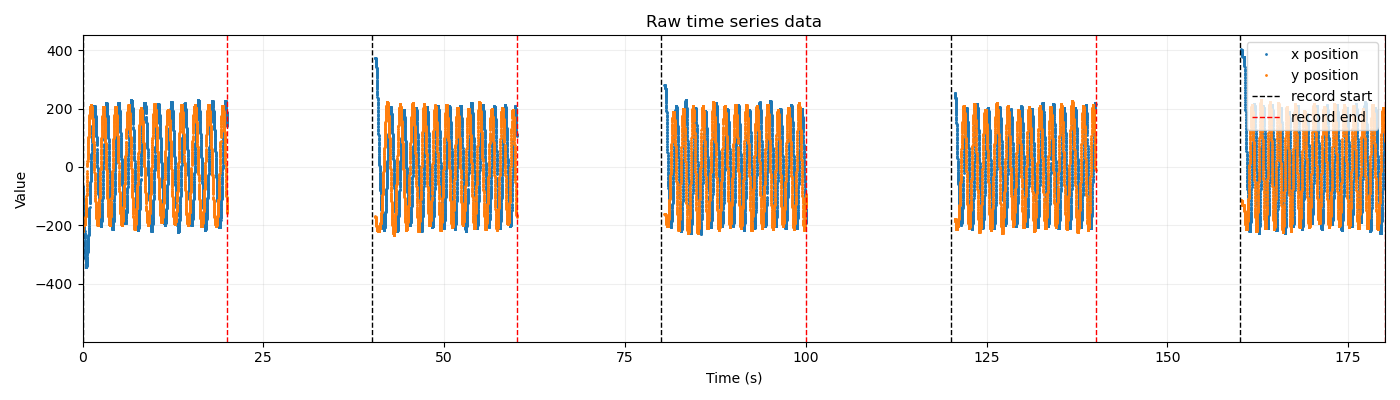

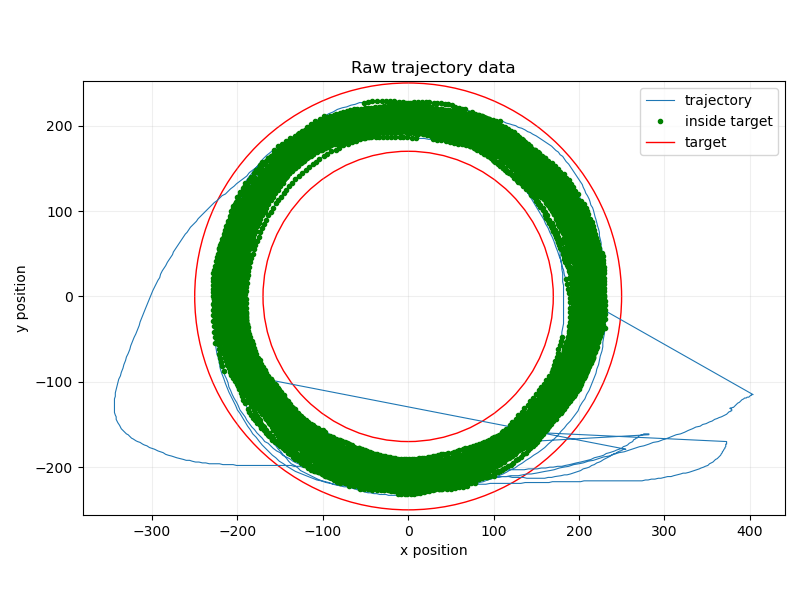

In [37]:
# Load raw CSVs and reproduce time series and trajectory using header + markers
# Uses only numpy, matplotlib.pyplot, and os

# Filenames
base_dir = os.getcwd()
raw_csv = os.path.join(base_dir, '001MoDe_R1.csv')
marker_csv = os.path.join(base_dir, '001MoDe_R1.marker.csv')

# Helper: find the header line index containing the provided header text
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    return None

# Read header parameters from the first line of the data CSV
with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
    header = f.readline().strip()

params = {}
for part in header.split(';'):
    part = part.strip()
    if not part:
        continue
    if ' ' in part:
        key, val = part.split(' ', 1)
        key = key.strip()
        val = val.strip()
        try:
            params[key] = float(val)
        except Exception:
            params[key] = val

center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw mouse data (timestamp, mouseX, mouseY, mouseInTarget)
header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
if header_line is None:
    raise RuntimeError('Could not find data header in 001MoDe_R1.csv')

raw_data = np.genfromtxt(
    raw_csv,
    delimiter=',',
    names=True,
    skip_header=header_line,
    dtype=None,
    encoding=None
)

# Extract arrays and sort by timestamp
timestamps = raw_data['timestamp'].astype(np.int64)
sort_idx = np.argsort(timestamps)
timestamps = timestamps[sort_idx]
mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]

# Relative coordinates (origin at task center), invert y so up is positive
x_rel = mouse_x - center_x
y_rel = (center_y - mouse_y)

# Parse marker file to get explicit record (work) intervals
record_starts = []
record_ends = []
with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
            parts = [p.strip() for p in s.split(',')]
            if len(parts) >= 3:
                try:
                    epoch_ms = int(parts[1])
                except Exception:
                    continue
                if 'DoCycleChange:DoRecord' in s:
                    record_starts.append(epoch_ms)
                elif 'DoCycleChange:DoPause' in s:
                    record_ends.append(epoch_ms)

# Align time axis to the first DoRecord marker
t0_record = int(record_starts[0]) if record_starts else int(timestamps[0])
t_sec = (timestamps - t0_record) / 1000.0

# Build arrays of start/end times in seconds relative to first DoRecord
start_times = np.array([(ms - t0_record) / 1000.0 for ms in record_starts], dtype=float)
end_times = np.array([(ms - t0_record) / 1000.0 for ms in record_ends], dtype=float)

# Build mask of samples that occur within any record interval
mask_record = np.zeros_like(t_sec, dtype=bool)
for s, e in zip(start_times, end_times):
    mask_record |= ((t_sec >= s) & (t_sec <= e))

# Plot 1: Raw time series with record on/off markers
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t_sec, x_rel, '.', ms=2, label='x position')
ax.plot(t_sec, y_rel, '.', ms=2, label='y position')
for s in start_times:
    ax.axvline(s, color='k', linestyle='--', linewidth=1, label='record start' if s == start_times[0] else None)
for e in end_times:
    ax.axvline(e, color='r', linestyle='--', linewidth=1, label='record end' if e == end_times[0] else None)
ax.set_title('Raw time series data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Value')
ax.set_xlim(0.0, float(np.max(t_sec)))
ax.legend(loc='upper right')
ax.grid(True, alpha=0.2)
fig.tight_layout()

# Plot 2: Raw trajectory with target annulus and in-target highlights (only during record)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
ax2.plot(x_rel[mask_record], y_rel[mask_record], color='tab:blue', linewidth=0.8, label='trajectory')
mask = (in_target == 1) & mask_record
if np.any(mask):
    ax2.plot(x_rel[mask], y_rel[mask], 'o', ms=3, color='green', label='inside target')

circle_inner = plt.Circle((0, 0), internal_r, fill=False, color='red', linewidth=1)
circle_outer = plt.Circle((0, 0), external_r, fill=False, color='red', linewidth=1)
ax2.add_artist(circle_inner)
ax2.add_artist(circle_outer)

# Add legend entry for target annulus
ax2.plot([], [], color='red', linewidth=1, label='target')

ax2.set_aspect('equal', adjustable='box')
ax2.set_title('Raw trajectory data')
ax2.set_xlabel('x position')
ax2.set_ylabel('y position')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.2)
fig2.tight_layout()